<center> 
    <h1> MBTI Personality Trait Classification using Twitter  </h1>
    <h4> <i> Author: Pavan Kumar K N </i>  </h4>
 </center>



In [1]:
#
# * File:    classic_persona.py
# *
# * Author1:  Pavan Kumar K N (pavankumar.karkekopp@ucalgary.ca)
# * Date:     20th May 2019
# * Summary of File:
# * Explore mbti_1.csv file acquired from https://www.kaggle.com/datasnaek/mbti-type
# * Apply state-of-the-art reported publicly
# * Build classifier model that is better using machine learning techniques

#Just making sure the right environment is running this script
import sys
sys.executable


'C:\\Users\\pavankumar.karkekopp\\.conda\\envs\\python35\\python.exe'

### Python libraries

In [2]:
#Read Data
import numpy as np
import pandas as pd
import sklearn
import re
import pickle

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk import word_tokenize

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

from numpy import loadtxt
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\pavankumar.karkekopp\.conda\envs\python35\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


### Dataset Description

In [3]:
#Read the dataset
mbti_data = pd.read_csv("data/mbti_1.csv")

#### Data Preview

In [4]:
#Print first 5 entries in the dataset
mbti_data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [5]:
raw_posts = mbti_data.posts.values

In [6]:
#Split posts by the delimiter, which is ||| as we can see in row 0 and 4 above
filtered_posts = [p.split("|||") for p in raw_posts]

In [7]:
#Example of two tweets from row 0
for i in range(5):
    print("Tweet #{}:   {}".format(i+1,filtered_posts[0][i]))


Tweet #1:   'http://www.youtube.com/watch?v=qsXHcwe3krw
Tweet #2:   http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg
Tweet #3:   enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks
Tweet #4:   What has been the most life-changing experience in your life?
Tweet #5:   http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.


#### MBTI Types Distribution in Data

In [8]:
count_types = mbti_data['type'].value_counts()

In [9]:
count_types = round(count_types/sum(count_types),4) * 100

In [10]:
count_types

INFP    21.12
INFJ    16.95
INTP    15.03
INTJ    12.58
ENTP     7.90
ENFP     7.78
ISTP     3.88
ISFP     3.12
ENTJ     2.66
ISTJ     2.36
ENFJ     2.19
ISFJ     1.91
ESTP     1.03
ESFP     0.55
ESFJ     0.48
ESTJ     0.45
Name: type, dtype: float64

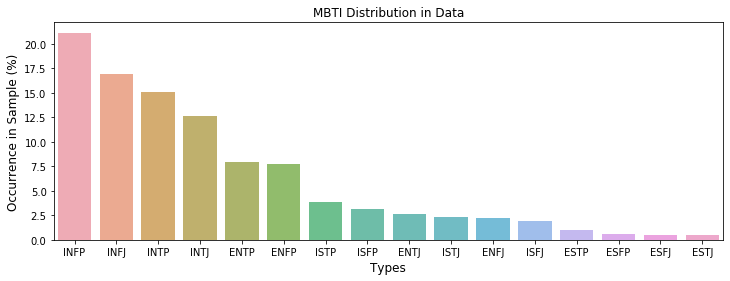

In [11]:
plt.figure(figsize=(12,4))
sns.barplot(count_types.index, count_types.values, alpha=0.8)
plt.ylabel('Occurrence in Sample (%)', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.title("MBTI Distribution in Data")
plt.show()

##### Unbalanced Dataset
Looking at the barplot, we see that the dataset is unbalanced and we need to take measures to correct for this eg. SMOTE (Synthetic Minority Oversampling Technique) and through k-fold cross-validation of model results

#### MBTI Types Distribution in General Population
https://www.myersbriggs.org/my-mbti-personality-type/my-mbti-results/how-frequent-is-my-type.htm?bhcp=1

In [12]:
genpop_types = count_types

In [13]:
genpop_types['ISTJ'] = 11.6
genpop_types['ISFJ'] = 13.8
genpop_types['INFJ'] = 1.5
genpop_types['INTJ'] = 2.1
genpop_types['ISTP'] = 5.4
genpop_types['ISFP'] = 8.8
genpop_types['INFP'] = 4.4
genpop_types['INTP'] = 3.3
genpop_types['ESTP'] = 4.3
genpop_types['ESFP'] = 8.5
genpop_types['ENFP'] = 8.1
genpop_types['ENTP'] = 3.2
genpop_types['ESTJ'] = 8.7
genpop_types['ESFJ'] = 12.3
genpop_types['ENFJ'] = 2.5
genpop_types['ENTJ'] = 1.8

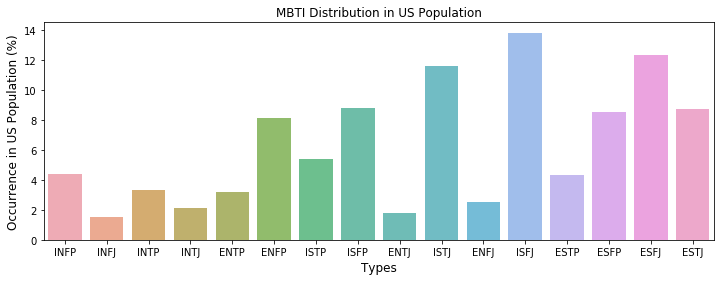

In [14]:
plt.figure(figsize=(12,4))
sns.barplot(genpop_types.index, genpop_types.values, alpha=0.8)
plt.ylabel('Occurrence in US Population (%)', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.title("MBTI Distribution in US Population")
plt.show()

Create 4 bit binary encoding of the class labels

In [15]:
def encode_types(row):
    t=row['type']

    I = 0
    N = 0
    T = 0
    J = 0
    
    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
    else: print('Could not identify label for I-E')
        
    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('Could not identify label for N-S')
        
    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
    else: print('Could not identify label for T-F')
        
    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    else: print('Could not identify label for J-P')
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

In [16]:
mbti_data_encoded = mbti_data.join(mbti_data.apply(lambda row: encode_types(row), axis=1))

In [17]:
mbti_data_encoded.head()

,type,posts,IE,NS,TF,JP
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,1,1


In [18]:
num_I = mbti_data_encoded['IE'].value_counts()[0]
num_E = mbti_data_encoded['IE'].value_counts()[1]
num_N = mbti_data_encoded['NS'].value_counts()[0]
num_S = mbti_data_encoded['NS'].value_counts()[1]
num_T = mbti_data_encoded['TF'].value_counts()[0]
num_F = mbti_data_encoded['TF'].value_counts()[1]
num_J = mbti_data_encoded['JP'].value_counts()[0]
num_P = mbti_data_encoded['JP'].value_counts()[1]

In [19]:
print ("Introversion (I) /  Extroversion (E):\t {} / {} ({}% / {}%)".format(num_I, num_E, round(num_I/(num_I+num_E)*100 ,2),round(num_E/(num_I+num_E)*100,2)))
print ("INtuition (N) – Sensing (S):\t {} / {} ({}% / {}%)".format(num_N, num_S, round(num_N/(num_N+num_S)*100 ,2),round(num_S/(num_N+num_S)*100,2)))
print ("Thinking (T) – Feeling (F):\t {} / {} ({}% / {}%)".format(num_T, num_F, round(num_T/(num_T+num_F)*100 ,2),round(num_F/(num_T+num_F)*100,2)))
print ("Judging (J) – Perceiving (P):\t {} / {} ({}% / {}%)".format(num_J, num_P, round(num_J/(num_J+num_P)*100 ,2),round(num_P/(num_J+num_P)*100,2)))

Introversion (I) /  Extroversion (E):	 1999 / 6676 (23.04% / 76.96%)
INtuition (N) – Sensing (S):	 1197 / 7478 (13.8% / 86.2%)
Thinking (T) – Feeling (F):	 4694 / 3981 (54.11% / 45.89%)
Judging (J) – Perceiving (P):	 5241 / 3434 (60.41% / 39.59%)


#### Pearson Feature Coorrelation

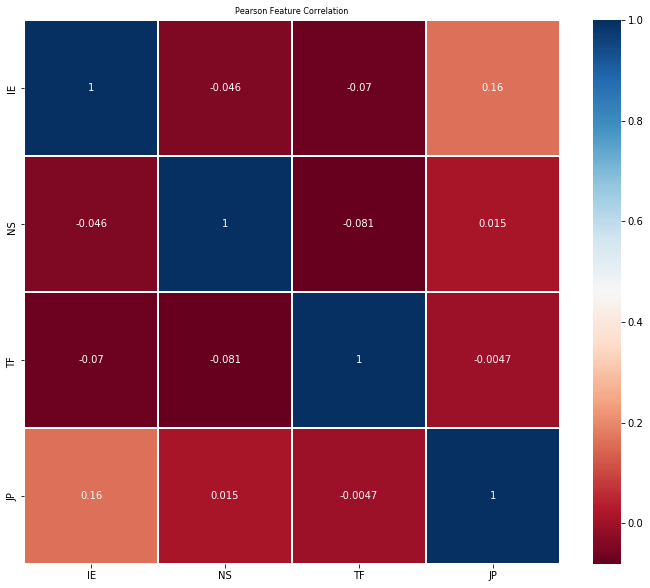

In [20]:
mbti_data_encoded[['IE','NS','TF','JP']].corr()

cmap = plt.cm.RdBu
corr = mbti_data_encoded[['IE','NS','TF','JP']].corr()
plt.figure(figsize=(12,10))
plt.title('Pearson Feature Correlation', size=8)
sns.heatmap(corr, cmap=cmap,  annot=True, linewidths=1)

This makes sense as we hope that each of the dimensions are unique and uncorrelated in expressing a person's psychology

In [21]:
#Function to binarize the types into simple lists instead of pandas.series
personality_binary = {'I':1, 'E':0, 'N':1,'S':0, 'T':1, 'F':0, 'J':1, 'P': 0}
binary_personality = [{1:'I', 0:'E'}, 
                      {1:'N', 0:'S'},
                      {1:'T', 0:'F'},
                      {1:'J', 0:'P'}]

def translate_personality(personality):
    # transform mbti to binary vector
    return [personality_binary[l] for l in personality]


def translate_binary(personality):
    # transform binary vector to mbti personality
    s = ""
    for i, l in enumerate(personality):
        s += binary_personality[i][l]
    return s



In [22]:
d = mbti_data_encoded.head(4)
list_personality_bin = np.array([translate_personality(p) for p in mbti_data_encoded.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)

Binarize MBTI list: 
[[1 1 0 1]
 [0 1 1 0]
 [1 1 1 0]
 ...
 [1 1 1 0]
 [1 1 0 0]
 [1 1 0 0]]


### Data Preprocessing
* Remove urls
* Keep only words and make it lowercase
* Lemmatize each word
* Remove MBTI profiles strings. Too many appear in the posts!

In [23]:
#List of strings to remove from the corpus
unique_type_list = ['INFJ', 
                    'ENTP', 
                    'INTP', 
                    'INTJ', 
                    'ENTJ', 
                    'ENFJ', 
                    'INFP', 
                    'ENFP',
                    'ISFP', 
                    'ISTP', 
                    'ISFJ', 
                    'ISTJ', 
                    'ESTP', 
                    'ESFP', 
                    'ESTJ', 
                    'ESFJ']

unique_type_list = [x.lower() for x in unique_type_list]

# Initialize for Lemmatization
stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()

def pre_process_data(data, remove_stop_words = True, remove_mbti_profiles = True):
    list_personality = []
    list_posts = []
    len_data = len(data)
    i=0
    
    for row in data.iterrows():
        i+=1
        if (i % 500 == 0 or i == 1 or i == len_data):
            print("%s of %s rows" % (i, len_data))

        ##### Remove and clean comments
        posts = row[1].posts
        temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)
        temp = re.sub("[^a-zA-Z]", " ", temp)
        temp = re.sub(' +', ' ', temp).lower()
        if remove_stop_words:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in stopwords.words("english")])
        else:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])
            
        if remove_mbti_profiles:
            for t in unique_type_list:
                temp = temp.replace(t,"")

        type_labelized = translate_personality(row[1].type)
        list_personality.append(type_labelized)
        list_posts.append(temp)

    list_posts = np.array(list_posts)
    list_personality = np.array(list_personality)
    return list_posts, list_personality


In [24]:
list_posts, list_personality  = pre_process_data(mbti_data_encoded, remove_stop_words=False)

1 of 8675 rows
500 of 8675 rows
1000 of 8675 rows
1500 of 8675 rows
2000 of 8675 rows
2500 of 8675 rows
3000 of 8675 rows
3500 of 8675 rows
4000 of 8675 rows
4500 of 8675 rows
5000 of 8675 rows
5500 of 8675 rows
6000 of 8675 rows
6500 of 8675 rows
7000 of 8675 rows
7500 of 8675 rows
8000 of 8675 rows
8500 of 8675 rows
8675 of 8675 rows


In [25]:
pickle.dump(list_posts, open("output/list_posts.p", "wb"))
pickle.dump(list_personality, open("output/list_personality.p", "wb"))

In [26]:
list_posts = pickle.load(open("output/list_posts.p", "rb"))
list_personality = pickle.load(open("output/list_personality.p", "rb"))

In [27]:
print("Num posts and personalities: ",  list_posts.shape, list_personality.shape)

Num posts and personalities:  (8675,) (8675, 4)


In [28]:
list_posts[0], list_personality[0]

('  and  moment sportscenter not top ten play prank what ha been the most life changing experience in your life on repeat for most of today may the perc experience immerse you the last thing my  friend posted on his facebook before committing suicide the next day rest in peace hello  sorry to hear of your distress it s only natural for a relationship to not be perfection all the time in every moment of existence try to figure the hard time a time of growth a welcome and stuff game set match prozac wellbrutin at least thirty minute of moving your leg and i don t mean moving them while sitting in your same desk chair weed in moderation maybe try edible a a healthier alternative basically come up with three item you ve determined that each type or whichever type you want to do would more than likely use given each type cognitive function and whatnot when left by all thing in moderation sims is indeed a video game and a good one at that note a good one at that is somewhat subjective in tha

In [29]:
list_personality[0]

array([1, 1, 0, 1])

In [30]:
# Posts to a matrix of token counts
cntizer = CountVectorizer(analyzer="word", 
                             max_features=1500, 
                             tokenizer=None,    
                             preprocessor=None, 
                             stop_words=None,  
                             max_df=0.7,
                             min_df=0.1) 

# Learn the vocabulary dictionary and return term-document matrix
print("CountVectorizer...")
X_cnt = cntizer.fit_transform(list_posts)

# Transform the count matrix to a normalized tf or tf-idf representation
tfizer = TfidfTransformer()

print("Tf-idf...")
# Learn the idf vector (fit) and transform a count matrix to a tf-idf representation
X_tfidf =  tfizer.fit_transform(X_cnt).toarray()

CountVectorizer...
Tf-idf...


In [31]:
feature_names = list(enumerate(cntizer.get_feature_names()))
feature_names

[(0, 'ability'),
 (1, 'able'),
 (2, 'above'),
 (3, 'absolutely'),
 (4, 'accept'),
 (5, 'accurate'),
 (6, 'across'),
 (7, 'act'),
 (8, 'action'),
 (9, 'actual'),
 (10, 'actually'),
 (11, 'add'),
 (12, 'admit'),
 (13, 'advice'),
 (14, 'afraid'),
 (15, 'after'),
 (16, 'again'),
 (17, 'against'),
 (18, 'age'),
 (19, 'ago'),
 (20, 'agree'),
 (21, 'ah'),
 (22, 'almost'),
 (23, 'alone'),
 (24, 'along'),
 (25, 'already'),
 (26, 'although'),
 (27, 'amazing'),
 (28, 'amount'),
 (29, 'angry'),
 (30, 'animal'),
 (31, 'annoying'),
 (32, 'another'),
 (33, 'answer'),
 (34, 'anxiety'),
 (35, 'anymore'),
 (36, 'anyone'),
 (37, 'anything'),
 (38, 'anyway'),
 (39, 'apparently'),
 (40, 'appreciate'),
 (41, 'approach'),
 (42, 'area'),
 (43, 'aren'),
 (44, 'argument'),
 (45, 'around'),
 (46, 'art'),
 (47, 'ask'),
 (48, 'asked'),
 (49, 'asking'),
 (50, 'aspect'),
 (51, 'assume'),
 (52, 'attention'),
 (53, 'attracted'),
 (54, 'avatar'),
 (55, 'avoid'),
 (56, 'aware'),
 (57, 'away'),
 (58, 'awesome'),
 (59, 'a

In [32]:
X_tfidf.shape

(8675, 841)

## Classification Pipeline
### XGBoost
* X: TF-IDF representation of posts
* Y: Binarized MBTI labels

In [33]:
print("X: Posts in tf-idf representation \n* 1st row:\n%s" % X_tfidf[0])

X: Posts in tf-idf representation 
* 1st row:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.06057509 0.
 0.07691555 0.06532408 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.09881064 0.         0.         0.04756555 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.10505636 0.         0.         0.         0.0826568  0.
 0.         0.10031611 0.05024804 0.         0.         0.
 0.         0.         0.04962642 0.         0.06527165 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.       

In [34]:
type_indicators = [ "IE: Introversion (I) / Extroversion (E)", "NS: Intuition (N) – Sensing (S)", 
                   "FT: Feeling (F) - Thinking (T)", "JP: Judging (J) – Perceiving (P)"  ]

for l in range(len(type_indicators)):
    print(type_indicators[l])


IE: Introversion (I) / Extroversion (E)
NS: Intuition (N) – Sensing (S)
FT: Feeling (F) - Thinking (T)
JP: Judging (J) – Perceiving (P)


In [35]:
print("MBTI 1st row: %s" % translate_binary(list_personality[0,:]))
print("Y: Binarized MBTI 1st row: %s" % list_personality[0,:])

MBTI 1st row: INFJ
Y: Binarized MBTI 1st row: [1 1 0 1]


In [36]:
# Posts in tf-idf representation
X = X_tfidf

# Let's train type indicator individually
for l in range(len(type_indicators)):
    print("\n\n{} ...".format(type_indicators[l]))
    
    # Let's train type indicator individually
    Y = list_personality[:,l]
    
    print(X.shape, Y.shape)

    # split data into train and test sets
    seed = 7
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
    
#     print("Number transactions X_train dataset: ", X_train.shape)
#     print("Number transactions y_train dataset: ", y_train.shape)
#     print("Number transactions X_test dataset: ", X_test.shape)
#     print("Number transactions y_test dataset: ", y_test.shape)

#     print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
#     print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

    sm = SMOTE(random_state=2)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

#     print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
#     print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

#     print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
#     print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

    # fit model on training data
    model = XGBClassifier(learning_rate=0.01,
                             n_estimators=5000,
                             max_depth=4,
                             min_child_weight=6,
                             colsample_bytree=0.8,
                             objective='binary:logistic',
                             nthread=8,
                             scale_pos_weight=1,
                             seed=7)

    model.fit(X_train_res, y_train_res)

    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
    f1_score_measure = sklearn.metrics.f1_score(y_test, predictions)
    print(" Accuracy: {:.2f}% \t F1-Score: {:.3f}".format(accuracy * 100.0, f1_score_measure))
    
    



IE: Introversion (I) / Extroversion (E) ...
(8675, 841) (8675,)
 Accuracy: 77.30% 	 F1-Score: 0.866


NS: Intuition (N) – Sensing (S) ...
(8675, 841) (8675,)
 Accuracy: 84.95% 	 F1-Score: 0.918


FT: Feeling (F) - Thinking (T) ...
(8675, 841) (8675,)
 Accuracy: 74.54% 	 F1-Score: 0.721


JP: Judging (J) – Perceiving (P) ...
(8675, 841) (8675,)
 Accuracy: 65.63% 	 F1-Score: 0.512


### SVM

In [37]:
# Posts in tf-idf representation
X = X_tfidf

# Let's train type indicator individually
for l in range(len(type_indicators)):
    print("\n\n{} ...".format(type_indicators[l]))
    
    # Let's train type indicator individually
    Y = list_personality[:,l]
    
    print(X.shape, Y.shape)

    # split data into train and test sets
    seed = 7
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
    
#     print("Number transactions X_train dataset: ", X_train.shape)
#     print("Number transactions y_train dataset: ", y_train.shape)
#     print("Number transactions X_test dataset: ", X_test.shape)
#     print("Number transactions y_test dataset: ", y_test.shape)

#     print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
#     print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

    sm = SMOTE(random_state=2)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

#     print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
#     print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

#     print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
#     print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

    # fit model on training data
    model = svm.SVC(gamma=0.01,
                          C=100.,
                          probability=True,
                          class_weight='balanced',
                          kernel='linear')

    model.fit(X_train_res, y_train_res)

    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
    f1_score_measure = sklearn.metrics.f1_score(y_test, predictions)
    print(" Accuracy: {:.2f}% \t F1-Score: {:.3f}".format(accuracy * 100.0, f1_score_measure))
    
    



IE: Introversion (I) / Extroversion (E) ...
(8675, 841) (8675,)
 Accuracy: 67.13% 	 F1-Score: 0.772


NS: Intuition (N) – Sensing (S) ...
(8675, 841) (8675,)
 Accuracy: 72.48% 	 F1-Score: 0.828


FT: Feeling (F) - Thinking (T) ...
(8675, 841) (8675,)
 Accuracy: 74.08% 	 F1-Score: 0.721


JP: Judging (J) – Perceiving (P) ...
(8675, 841) (8675,)
 Accuracy: 63.01% 	 F1-Score: 0.553


In [38]:
pd.DataFrame(list_personality[:,1])[0].value_counts()

1    7478
0    1197
Name: 0, dtype: int64

#### Hyperparamter Tuning

In [39]:
def modelfit(alg, X, Y, useTrainCV=True, cv_folds=10, early_stopping_rounds=50):
    
    test_size = 0.33
    seed = 7
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X, label=Y)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval =True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_test)
    dtrain_predprob = alg.predict_proba(X_test)[:,1]
    
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy: {:.3f}".format(metrics.accuracy_score(y_test, dtrain_predictions)))
    print("AUC Score (Test): {}".format(metrics.roc_auc_score(y_test, dtrain_predprob)))
    print("F1-Score (Test): {}".format(metrics.f1_score(y_test, dtrain_predictions)))
    
    f_scores = alg.get_booster().get_fscore()
    feat_imp = pd.Series(f_scores).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
#     pickle.dump(f_scores, open("output/f_scores.p", "wb"))


C:\Users\pavankumar.karkekopp\.conda\envs\python35\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[0]	train-auc:0.633451+0.00799019	test-auc:0.58087+0.0298943
[1]	train-auc:0.682376+0.0162827	test-auc:0.603468+0.032414
[2]	train-auc:0.71136+0.0122618	test-auc:0.612529+0.0293005
[3]	train-auc:0.734571+0.0107007	test-auc:0.619175+0.0325484
[4]	train-auc:0.750647+0.0107667	test-auc:0.625262+0.0316098
[5]	train-auc:0.767115+0.00798278	test-auc:0.626336+0.0298029
[6]	train-auc:0.779394+0.00708814	test-auc:0.629633+0.0297461
[7]	train-auc:0.78954+0.0072721	test-auc:0.633355+0.0274838
[8]	train-auc:0.800811+0.005567	test-auc:0.637968+0.0241116
[9]	train-auc:0.812592+0.00844354	test-auc:0.640686+0.0237364
[10]	train-auc:0.822228+0.00758547	test-auc:0.642304+0.0231154
[11]	train-auc:0.83242+0.007743	test-auc:0.644365+0.0210562
[12]	train-auc:0.839673+0.00683643	test-auc:0.644749+0.0210106
[13]	train-auc:0.846306+0.0057113	test-auc:0.646109+0.0203976
[14]	train-auc:0.85451+0.00765176	test-auc:0.647141+0.0221055
[15]	train-auc:0.861645+0.00737268	test-auc:0.649985+0.0211808
[16]	train-auc:0.8

[130]	train-auc:0.99934+0.000184763	test-auc:0.700584+0.0251174
[131]	train-auc:0.999358+0.000183551	test-auc:0.700551+0.0255034
[132]	train-auc:0.999386+0.000171733	test-auc:0.700456+0.0261119
[133]	train-auc:0.999419+0.000165882	test-auc:0.701187+0.0263191
[134]	train-auc:0.999442+0.000161395	test-auc:0.700703+0.0263639
[135]	train-auc:0.999464+0.000153547	test-auc:0.700539+0.0268913
[136]	train-auc:0.999488+0.000153352	test-auc:0.700508+0.0267852
[137]	train-auc:0.999501+0.000150267	test-auc:0.700234+0.0268329
[138]	train-auc:0.99952+0.000147252	test-auc:0.700674+0.0272086
[139]	train-auc:0.999536+0.000142656	test-auc:0.700302+0.0275542
[140]	train-auc:0.999556+0.000141198	test-auc:0.700449+0.0271461
[141]	train-auc:0.999568+0.000136758	test-auc:0.69994+0.0265106
[142]	train-auc:0.999587+0.000129702	test-auc:0.700246+0.0267281
[143]	train-auc:0.999601+0.000129613	test-auc:0.700211+0.0266925
[144]	train-auc:0.999609+0.00013046	test-auc:0.70045+0.0268414
[145]	train-auc:0.999626+0.000

[257]	train-auc:0.999993+4.86724e-06	test-auc:0.704624+0.0259571
[258]	train-auc:0.999993+4.8949e-06	test-auc:0.704624+0.0261789
[259]	train-auc:0.999994+4.69468e-06	test-auc:0.704668+0.025804
[260]	train-auc:0.999994+4.35431e-06	test-auc:0.704963+0.0254512
[261]	train-auc:0.999994+4.33128e-06	test-auc:0.705076+0.0258148
[262]	train-auc:0.999994+4.10974e-06	test-auc:0.704722+0.0265209
[263]	train-auc:0.999994+3.97995e-06	test-auc:0.70464+0.0268214
[264]	train-auc:0.999995+3.67287e-06	test-auc:0.704765+0.0269746
[265]	train-auc:0.999995+3.68917e-06	test-auc:0.704777+0.0269401
[266]	train-auc:0.999995+3.75366e-06	test-auc:0.7049+0.0272897
[267]	train-auc:0.999996+3.32415e-06	test-auc:0.704606+0.0270834
[268]	train-auc:0.999995+3.37787e-06	test-auc:0.704385+0.0274287
[269]	train-auc:0.999996+2.96816e-06	test-auc:0.704503+0.0272199
[270]	train-auc:0.999996+2.9e-06	test-auc:0.704855+0.0271405
[271]	train-auc:0.999996+3.01496e-06	test-auc:0.704478+0.0269045
[272]	train-auc:0.999996+2.92575e-

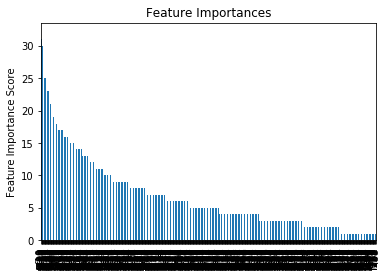

In [40]:
### PARAM SET 1
Y = list_personality[:,1]

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=7)

modelfit(xgb1, X_tfidf, Y)


C:\Users\pavankumar.karkekopp\.conda\envs\python35\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[0]	train-auc:0.600172+0.00995732	test-auc:0.570632+0.0199076
[1]	train-auc:0.651635+0.00854539	test-auc:0.609683+0.0241087
[2]	train-auc:0.682363+0.00834588	test-auc:0.618907+0.0188371
[3]	train-auc:0.706752+0.00538777	test-auc:0.624647+0.0278911
[4]	train-auc:0.7252+0.00409516	test-auc:0.628953+0.0207006
[5]	train-auc:0.739193+0.00347527	test-auc:0.62595+0.0253252
[6]	train-auc:0.750452+0.00425711	test-auc:0.626447+0.0219612
[7]	train-auc:0.763432+0.00285778	test-auc:0.631417+0.0198519
[8]	train-auc:0.774473+0.00291841	test-auc:0.627707+0.0194772
[9]	train-auc:0.782681+0.00413252	test-auc:0.625909+0.0200615
[10]	train-auc:0.792816+0.00443958	test-auc:0.632177+0.0210208
[11]	train-auc:0.801394+0.0046352	test-auc:0.630817+0.0258429
[12]	train-auc:0.809821+0.00470067	test-auc:0.6329+0.0275365
[13]	train-auc:0.816872+0.00435448	test-auc:0.632839+0.0247289
[14]	train-auc:0.823941+0.00376632	test-auc:0.630818+0.0238979
[15]	train-auc:0.830331+0.00293958	test-auc:0.633802+0.0213727
[16]	tra

[131]	train-auc:0.997788+0.00043847	test-auc:0.66202+0.0211206
[132]	train-auc:0.997862+0.000432606	test-auc:0.662252+0.0210474
[133]	train-auc:0.997963+0.000431871	test-auc:0.662115+0.0206749
[134]	train-auc:0.99805+0.000427477	test-auc:0.661508+0.0203356
[135]	train-auc:0.998108+0.00040754	test-auc:0.661271+0.0198743
[136]	train-auc:0.998181+0.000377607	test-auc:0.660572+0.0200114
[137]	train-auc:0.998267+0.000380167	test-auc:0.660312+0.0198643
[138]	train-auc:0.998384+0.000374621	test-auc:0.660192+0.0202206
[139]	train-auc:0.99847+0.000372962	test-auc:0.659731+0.0209828
[140]	train-auc:0.998569+0.000313537	test-auc:0.659131+0.0207792
[141]	train-auc:0.998656+0.000309919	test-auc:0.659909+0.0208746
[142]	train-auc:0.998713+0.000289192	test-auc:0.660003+0.0215676
[143]	train-auc:0.998771+0.000266696	test-auc:0.660311+0.0214536
[144]	train-auc:0.99884+0.00026926	test-auc:0.659833+0.021924
[145]	train-auc:0.998901+0.000236104	test-auc:0.660334+0.0220132
[146]	train-auc:0.998968+0.000233

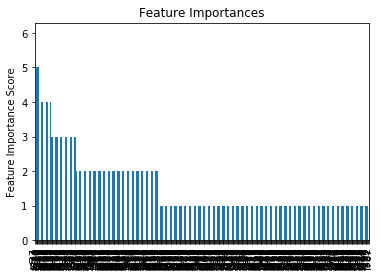

In [41]:
### PARAM SET 2
Y = list_personality[:,1]

xgb1 = XGBClassifier(
 learning_rate =0.6,
 n_estimators=300,
 max_depth=3,
 min_child_weight=7,
 gamma=0,
 subsample=0.93,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=7)

modelfit(xgb1, X_tfidf, Y)


In [42]:
feature_scores = pickle.load(open("output/f_scores.p", "rb"))

In [43]:
sorted_feature_scores = pd.Series(feature_scores).sort_values(ascending=False)
sorted_feature_scores

f772    30
f538    28
f609    26
f588    25
f9      23
f738    23
f678    22
f769    20
f482    19
f66     18
f440    17
f552    17
f637    17
f558    17
f786    17
f334    17
f214    17
f16     16
f426    16
f267    16
f465    15
f583    15
f665    15
f685    15
f765    15
f655    15
f243    15
f331    15
f33     14
f288    14
        ..
f333     1
f62      1
f379     1
f274     1
f230     1
f601     1
f499     1
f43      1
f80      1
f227     1
f236     1
f373     1
f59      1
f13      1
f746     1
f360     1
f48      1
f46      1
f263     1
f143     1
f375     1
f576     1
f574     1
f472     1
f453     1
f251     1
f79      1
f304     1
f187     1
f50      1
Length: 719, dtype: int64

##### Top-100 Important Words for this model

In [44]:
top_n = 100
i=0
for val in np.squeeze(np.array(sorted_feature_scores.axes)):
    print(feature_names[int(val[1:])])
    i += 1
    if(i>top_n):
        break

(772, 'unsure')
(538, 'pay')
(609, 'romantic')
(588, 'rather')
(9, 'actual')
(738, 'three')
(678, 'spend')
(769, 'unfortunately')
(482, 'must')
(66, 'become')
(440, 'made')
(552, 'place')
(637, 'she')
(558, 'point')
(786, 'walk')
(334, 'hey')
(214, 'emotion')
(16, 'again')
(426, 'll')
(267, 'figure')
(465, 'might')
(583, 'quite')
(665, 'somewhat')
(685, 'statement')
(765, 'typing')
(655, 'situation')
(243, 'extremely')
(331, 'helped')
(33, 'answer')
(288, 'future')
(114, 'class')
(403, 'le')
(85, 'both')
(174, 'depends')
(99, 'care')
(213, 'else')
(74, 'better')
(670, 'sort')
(595, 'reason')
(190, 'doesn')
(223, 'enough')
(253, 'fan')
(707, 'support')
(386, 'kill')
(691, 'stop')
(310, 'haha')
(91, 'bring')
(681, 'start')
(423, 'little')
(629, 'sensitive')
(532, 'part')
(404, 'lead')
(56, 'aware')
(285, 'fun')
(455, 'meet')
(205, 'easier')
(90, 'break')
(756, 'true')
(461, 'mentioned')
(359, 'im')
(569, 'pretty')
(347, 'hope')
(468, 'minute')
(720, 'teacher')
(514, 'once')
(698, 'studen

##### Tune __max_depth__ and __min_child_weight__

In [45]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,12,2)
}


In [46]:
X = X_tfidf

test_size = 0.33
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)


In [47]:
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, 
                                                   n_estimators=140, 
                                                   max_depth=5,
                                                   min_child_weight=1, 
                                                   gamma=0, 
                                                   subsample=0.8, 
                                                   colsample_bytree=0.8,
                                                   objective= 'binary:logistic', 
                                                   nthread=4, 
                                                   scale_pos_weight=1, 
                                                   seed=seed), 
                        param_grid = param_test1, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch1.fit(X_train,y_train)



GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=1,
                                     missing=None, n_estimators=140, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=7, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 12, 2)},
             pre_dispatch='2*n_jobs', refit=True, retur

In [48]:
gsearch1.cv_results_

{'mean_fit_time': array([10.9132731 , 10.57755356, 10.92096105, 10.62725511, 10.65465569,
        10.51651258, 15.64605551, 15.2202703 , 15.987076  , 15.5726851 ,
        15.62270455, 15.12272654, 21.33005562, 20.12013078, 21.11325631,
        20.54500942, 20.54714465, 18.75532827, 28.1355855 , 25.28656192,
        25.36934161, 24.75976253, 23.75902424, 19.25459833]),
 'std_fit_time': array([1.73422176, 0.84584782, 0.95145231, 0.84795725, 0.5601103 ,
        1.20479977, 2.35123053, 0.93558148, 1.30354882, 0.82142959,
        0.93310408, 0.67720286, 1.19031662, 1.3456141 , 2.44234074,
        2.19472935, 3.66630654, 1.35683936, 3.18761479, 2.44402779,
        3.43207371, 3.03821212, 2.09297957, 3.58858645]),
 'mean_score_time': array([0.07111554, 0.04099526, 0.03482456, 0.03859854, 0.03590755,
        0.0380002 , 0.03650346, 0.04099255, 0.03789902, 0.03789916,
        0.04039621, 0.04148936, 0.04418573, 0.03660574, 0.03780122,
        0.03771472, 0.03929558, 0.04827194, 0.04767351, 0.03

In [49]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 9, 'min_child_weight': 1}, 0.6776520791399387)

In [50]:
param_test2 = {
 'max_depth':range(3,5,2),
 'min_child_weight':range(1,3,2)
}


In [51]:
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, 
                                                   n_estimators=140, 
                                                   max_depth=5,
                                                   min_child_weight=1, 
                                                   gamma=0, 
                                                   subsample=0.8, 
                                                   colsample_bytree=0.8,
                                                   objective= 'binary:logistic', 
                                                   nthread=4, 
                                                   scale_pos_weight=1, 
                                                   seed=seed), 
                        param_grid = param_test2, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch2.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=1,
                                     missing=None, n_estimators=140, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=7, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'max_depth': range(3, 5, 2),
                         'min_child_weight': range(1, 3, 2)},
             pre_dispatch='2*n_jobs', refit=True, return_

In [52]:
gsearch2.cv_results_

{'mean_fit_time': array([9.43471274]),
 'std_fit_time': array([2.25646544]),
 'mean_score_time': array([0.03071804]),
 'std_score_time': array([0.00765859]),
 'param_max_depth': masked_array(data=[3],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 3, 'min_child_weight': 1}],
 'split0_test_score': array([0.64953888]),
 'split1_test_score': array([0.69341351]),
 'split2_test_score': array([0.67721364]),
 'split3_test_score': array([0.67992877]),
 'split4_test_score': array([0.65625137]),
 'mean_test_score': array([0.67126923]),
 'std_test_score': array([0.01611482]),
 'rank_test_score': array([1])}

In [53]:
gsearch2.best_score_, gsearch2.best_params_

(0.6712692347485845, {'max_depth': 3, 'min_child_weight': 1})

#### SVM Hyperparameter Optimization

In [54]:
def modelfitSVC(X, y, useTrainCV=True, cv_folds=10, early_stopping_rounds=50):
    
#     test_size = 0.33
#     seed = 7
#     X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
    Cs = [0.001, 0.01, 0.1, 1, 10]
    param_grid = {'C': Cs}
    grid_search = GridSearchCV(svm.SVC(kernel='linear'), param_grid, cv=cv_folds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

#     if useTrainCV:
#         xgb_param = alg.get_xgb_params()
#         xgtrain = xgb.DMatrix(X, label=Y)
#         cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval =True)
#         alg.set_params(n_estimators=cvresult.shape[0])
    
#     #Fit the algorithm on the data
#     alg.fit(X_train, y_train,eval_metric='auc')
        
#     #Predict training set:
#     dtrain_predictions = alg.predict(X_test)
#     dtrain_predprob = alg.predict_proba(X_test)[:,1]
    
    
#     #Print model report:
#     print("\nModel Report")
#     print("Accuracy: {:.3f}".format(metrics.accuracy_score(y_test, dtrain_predictions)))
#     print("AUC Score (Test): {}".format(metrics.roc_auc_score(y_test, dtrain_predprob)))
#     print("F1-Score (Test): {}".format(metrics.f1_score(y_test, dtrain_predictions)))
    
#     f_scores = alg.get_booster().get_fscore()
#     feat_imp = pd.Series(f_scores).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')
# #     pickle.dump(f_scores, open("output/f_scores.p", "wb"))

In [55]:
X = X_tfidf

# Let's train type indicator individually
for l in range(len(type_indicators)):
    print("\n\n{} ...".format(type_indicators[l]))
    
    # Let's train type indicator individually
    Y = list_personality[:,l]
    
    print(X.shape, Y.shape)

    # split data into train and test sets
    seed = 7
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
    
#     print("Number transactions X_train dataset: ", X_train.shape)
#     print("Number transactions y_train dataset: ", y_train.shape)
#     print("Number transactions X_test dataset: ", X_test.shape)
#     print("Number transactions y_test dataset: ", y_test.shape)

#     print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
#     print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

    sm = SMOTE(random_state=2)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

#     print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
#     print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

#     print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
#     print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

    # fit model on training data
    result = modelfitSVC(X_train_res, y_train_res)
    print(result)

#     # make predictions for test data
#     y_pred = model.predict(X_test)
#     predictions = [round(value) for value in y_pred]
#     # evaluate predictions
#     accuracy = accuracy_score(y_test, predictions)
#     f1_score_measure = sklearn.metrics.f1_score(y_test, predictions)
#     print(" Accuracy: {:.2f}% \t F1-Score: {:.3f}".format(accuracy * 100.0, f1_score_measure))



IE: Introversion (I) / Extroversion (E) ...
(8675, 841) (8675,)
{'C': 10}


NS: Intuition (N) – Sensing (S) ...
(8675, 841) (8675,)
{'C': 10}


FT: Feeling (F) - Thinking (T) ...
(8675, 841) (8675,)
{'C': 1}


JP: Judging (J) – Perceiving (P) ...
(8675, 841) (8675,)
{'C': 1}


# Neural Network Model

### Python Libraries

In [56]:
from __future__ import print_function

import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from keras.models import Model

mbti_1 = pd.read_csv('data/mbti_1.csv') 
posts = mbti_1.posts
labels = mbti_1.type

BASE_DIR = ''
GLOVE_DIR = "data/glove.twitter.27B"
MAX_SEQUENCE_LENGTH = 600
MAX_NB_WORDS = 2000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2


Using TensorFlow backend.


In [57]:
# build index mapping words in the embeddings set to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.100d.txt'), encoding="utf=8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Indexing word vectors.
Found 1193514 word vectors.


In [58]:
# prepare text samples and their labels
print('Processing text dataset')

texts = [post.replace("link", "") for post in list_posts] # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = np.array(list_personality_bin)
# list of label ids


print('Found %s texts.' % len(texts))


Processing text dataset
Found 8675 texts.


In [59]:
# vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 88645 unique tokens.
Shape of data tensor: (8675, 600)
Shape of label tensor: (8675, 4)


In [60]:
labels

array([[1, 1, 0, 1],
       [0, 1, 1, 0],
       [1, 1, 1, 0],
       ...,
       [1, 1, 1, 0],
       [1, 1, 0, 0],
       [1, 1, 0, 0]])

In [61]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

In [62]:
print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

Preparing embedding matrix.


In [63]:
print('Training convolutional network.')

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(64, 4, activation='relu')(embedded_sequences)
x = MaxPooling1D(4)(x)
x = Conv1D(64, 4, activation='relu')(x)
x = MaxPooling1D(4)(x)
x = Conv1D(64, 4, activation='relu')(x)
x = MaxPooling1D(25)(x)  # global max pooling
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
preds = Dense(4, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

Training convolutional network.
Instructions for updating:
Colocations handled automatically by placer.


In [64]:
# Summer is coming!
print('Training convolutional network.')

model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=100, batch_size=256)

Training convolutional network.
Instructions for updating:
Use tf.cast instead.
Train on 6940 samples, validate on 1735 samples
Epoch 1/100
6940/6940 [==============================] - 25s 4ms/step - loss: 3.3594 - acc: 0.3589 - val_loss: 3.3440 - val_acc: 0.2127
Epoch 2/100
6940/6940 [==============================] - 13s 2ms/step - loss: 3.3149 - acc: 0.3510 - val_loss: 3.3383 - val_acc: 0.2127
Epoch 3/100
6940/6940 [==============================] - 13s 2ms/step - loss: 3.3024 - acc: 0.2556 - val_loss: 3.3446 - val_acc: 0.7412
Epoch 4/100
6940/6940 [==============================] - 14s 2ms/step - loss: 3.2937 - acc: 0.2803 - val_loss: 3.3413 - val_acc: 0.2415
Epoch 5/100
6940/6940 [==============================] - 13s 2ms/step - loss: 3.2837 - acc: 0.2553 - val_loss: 3.3302 - val_acc: 0.2617
Epoch 6/100
6940/6940 [==============================] - 14s 2ms/step - loss: 3.2672 - acc: 0.2878 - val_loss: 3.3312 - val_acc: 0.2115
Epoch 7/100
6940/6940 [==============================] -

6940/6940 [==============================] - 12s 2ms/step - loss: 2.5701 - acc: 0.4311 - val_loss: 4.3328 - val_acc: 0.3666
Epoch 59/100
6940/6940 [==============================] - 13s 2ms/step - loss: 2.5717 - acc: 0.4470 - val_loss: 4.1663 - val_acc: 0.3499
Epoch 60/100
6940/6940 [==============================] - 12s 2ms/step - loss: 2.5701 - acc: 0.4476 - val_loss: 4.1421 - val_acc: 0.3199
Epoch 61/100
6940/6940 [==============================] - 13s 2ms/step - loss: 2.5689 - acc: 0.4484 - val_loss: 4.1334 - val_acc: 0.3199
Epoch 62/100
6940/6940 [==============================] - 12s 2ms/step - loss: 2.5678 - acc: 0.4386 - val_loss: 4.3322 - val_acc: 0.4046
Epoch 63/100
6940/6940 [==============================] - 13s 2ms/step - loss: 2.5665 - acc: 0.4484 - val_loss: 4.1807 - val_acc: 0.3343
Epoch 64/100
6940/6940 [==============================] - 12s 2ms/step - loss: 2.5532 - acc: 0.4464 - val_loss: 4.3683 - val_acc: 0.3141
Epoch 65/100
6940/6940 [==============================

### Bi-directional LSTM

In [68]:
# Bidirectional LSTM

import numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, CuDNNLSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

VALIDATION_SPLIT = 0.2
MAX_NB_WORDS = 20000

# fix random seed for reproducibility
numpy.random.seed(7)

# Tokenize
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(list_posts)
sequences = tokenizer.texts_to_sequences(list_posts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 88675 unique tokens.


In [69]:
# split the data into a training set and a validation set

from sklearn.model_selection import train_test_split
from keras import metrics
x_train, x_val, y_train, y_test = train_test_split(sequences, list_personality_bin, test_size=0.3, random_state=0, stratify=list_personality)

# truncate and pad input sequences
max_sentence_length = 600
X_train = sequence.pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(x_val, maxlen=MAX_SEQUENCE_LENGTH)

max_features = 2000
batch_size = 64

print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)


sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Bidirectional(CuDNNLSTM(256))(embedded_sequences)
preds = Dense(4, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[metrics.categorical_accuracy])

# model = Sequential()
# model.add(Embedding(max_features, 256, input_length=max_sentence_length))
# model.add(Bidirectional(LSTM(64)))
# model.add(Dense(4, activation='softmax'))
# model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

print('Train...')
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=4,
          validation_data=[X_test, y_test])

x_train shape: (6072, 600)
x_test shape: (2603, 600)
Train...
Train on 6072 samples, validate on 2603 samples
Epoch 1/4
6072/6072 [==============================] - 242s 40ms/step - loss: 3.3387 - categorical_accuracy: 0.3598 - val_loss: 3.3179 - val_categorical_accuracy: 0.2985
Epoch 2/4
6072/6072 [==============================] - 239s 39ms/step - loss: 3.3154 - categorical_accuracy: 0.3554 - val_loss: 3.3294 - val_categorical_accuracy: 0.2101
Epoch 3/4
6072/6072 [==============================] - 237s 39ms/step - loss: 3.3008 - categorical_accuracy: 0.3608 - val_loss: 3.3210 - val_categorical_accuracy: 0.3139
Epoch 4/4
6072/6072 [==============================] - 235s 39ms/step - loss: 3.2908 - categorical_accuracy: 0.3651 - val_loss: 3.3249 - val_categorical_accuracy: 0.4399
